In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow

import logging
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
from datetime import datetime

### Load Dataset

In [2]:
logging.info('Load Training Set')

In [243]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)

try:
    df_train = pd.read_csv('../data/train_final.csv', na_values=['?', None, 'undefined'])
except FileNotFoundError:
    print('Error: File not found')

In [ ]:
df_train = df_train.reindex(index=df_train.index[::-1])
df_train.head()

In [4]:
logging.info('Load Test Set')

In [248]:
try:
    df_test = pd.read_csv('../data/test_final.csv', na_values=['?', None, 'undefined'])
except FileNotFoundError:
    print('Error: File not found')

In [ ]:
df_test = df_test.reindex(index=df_test.index[::-1])
df_test.head()

### Check whether your time Series Data is Stationary

In [6]:
sales = df_train['Sales'].values
split = len(sales) // 2
X1, X2 = sales[0:split], sales[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5648.631594, mean2=5899.006105
variance1=14290518.018749, variance2=15321971.236433


The data is not statonary because the **means** and **variances** are significantly different

###  Autocorrelation and partial autocorrelation

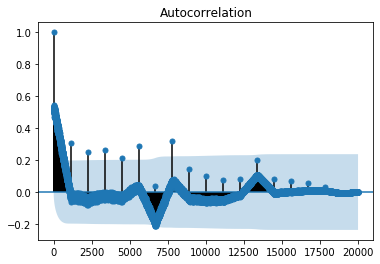

In [7]:
plot_acf(sales[:20000])
plt.show()

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

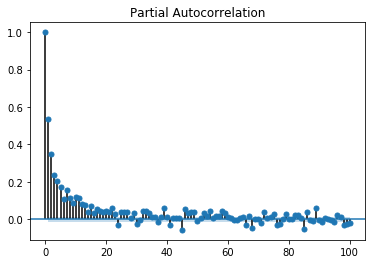

In [8]:
plot_pacf(sales[:20000], lags=100)
plt.show()

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

### Scale Data

In [227]:
store_id = 16
X = df_train[df_train['Store'] == store_id].values


sc_x = MinMaxScaler(feature_range=(-1, 1))
sc_y = MinMaxScaler(feature_range=(-1, 1))


y = X[:,[-1]][6:]
X = X[:,:-1]

print(f'average daily earning for store number {store_id} is', y.mean())

X = sc_x.fit_transform(X)
y = sc_y.fit_transform(y)


X.shape, y.shape

average daily earning for store number 16 is 6351.589743589743


((942, 18), (936, 1))

In [228]:
#X[1], y[1]

In [229]:
def window(array, size):
    l = []
    for i in range(len(array)-size+1):
        l.append(array[i:i+size])
    return np.array(l)
X = window(X,7)
X.shape

(936, 7, 18)

### Train Test Split

In [230]:
ind = int(len(X)*90/100)
X_train, X_test, y_train, y_test = X[:ind], X[ind:], y[:ind], y[ind:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((842, 7, 18), (94, 7, 18), (842, 1), (94, 1))

## Window Dataset

In [223]:
regressor = Sequential()

regressor.add(LSTM(20, activation = 'sigmoid', return_sequences=True, input_shape = (7, 18)))
regressor.add(LSTM(10))
regressor.add(Dense(1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 7, 20)             3120      
_________________________________________________________________
lstm_25 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 4,371
Trainable params: 4,371
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [224]:
regressor.fit(X_train, y_train, batch_size = 2, epochs = 50)

Epoch 1/50
842/842 [==============================] - 14s 17ms/sample - loss: 0.1357
Epoch 2/50
842/842 [==============================] - 4s 5ms/sample - loss: 0.0371
Epoch 3/50
842/842 [==============================] - 4s 5ms/sample - loss: 0.0239
Epoch 4/50
842/842 [==============================] - 5s 6ms/sample - loss: 0.0189
Epoch 5/50
842/842 [==============================] - 4s 5ms/sample - loss: 0.0169
Epoch 6/50
842/842 [==============================] - 4s 5ms/sample - loss: 0.0159
Epoch 7/50
842/842 [==============================] - 4s 5ms/sample - loss: 0.0157
Epoch 8/50
842/842 [==============================] - 4s 5ms/sample - loss: 0.0155
Epoch 9/50
842/842 [==============================] - 5s 6ms/sample - loss: 0.0149
Epoch 10/50
842/842 [==============================] - 5s 6ms/sample - loss: 0.0146
Epoch 11/50
842/842 [==============================] - ETA: 0s - loss: 0.013 - 4s 5ms/sample - loss: 0.0137
Epoch 12/50
842/842 [==============================] - 4s 5

### Test Model

r2 score: 0.9564035453684754
root mean squared error: 752.9189567140689


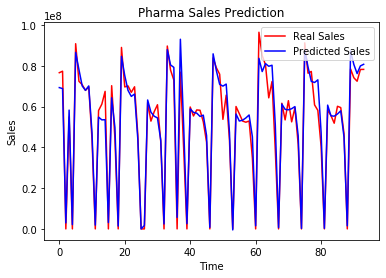

In [238]:

y_pred = regressor.predict(X_test)
#predicted_price = sc.inverse_transform(predicted_price)
y_pred_inv = sc_y.inverse_transform(y_pred)
y_test_inv = sc_y.inverse_transform(y_test)


print('r2 score:', r2_score(y_test_inv, y_pred_inv))
print('root mean squared error:', mean_squared_error(y_test_inv, y_pred_inv)**0.5)

plt.plot(sc_y.inverse_transform(y_test_inv), color = 'red', label = 'Real Sales')
plt.plot(sc_y.inverse_transform(y_pred_inv), color = 'blue', label = 'Predicted Sales')
plt.title('Pharma Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Save Model

In [240]:
regressor.save(f"../models/store_{store_id}_lstm_model.h5")